In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import timedelta
from dateutil.parser import parse

data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_99403/278595787.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Load mobility data files

### Load/Clean Simple Heatwave Data

In [2]:
#heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/heatwave_control_90_v2.csv')
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/nigeria/THI_heatwave_control_90.csv')

In [3]:
heatwave_control['Heat Wave Duration'].describe()

count    2275.000000
mean        4.041758
std         2.815730
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        15.000000
Name: Heat Wave Duration, dtype: float64

In [4]:
heatwave_control['control_day'] = [parse(x) for x in heatwave_control['control_day']]
heatwave_control['datetime'] = [parse(x) for x in heatwave_control['datetime']]

In [5]:
(heatwave_control['datetime'] - heatwave_control['control_day']).describe()

count                          9195
mean     15 days 12:08:22.707993474
std       8 days 22:01:01.963388703
min                 7 days 00:00:00
25%                 7 days 00:00:00
50%                14 days 00:00:00
75%                21 days 00:00:00
max                56 days 00:00:00
dtype: object

In [6]:
heatwave_control['diff'] = (heatwave_control['datetime'] - heatwave_control['control_day'])

In [7]:
temp = pd.DataFrame(heatwave_control['diff'].value_counts()).sort_index()

In [8]:
temp.columns = ['Number of Instances']

Text(0, 0.5, 'Heat and Control Difference')

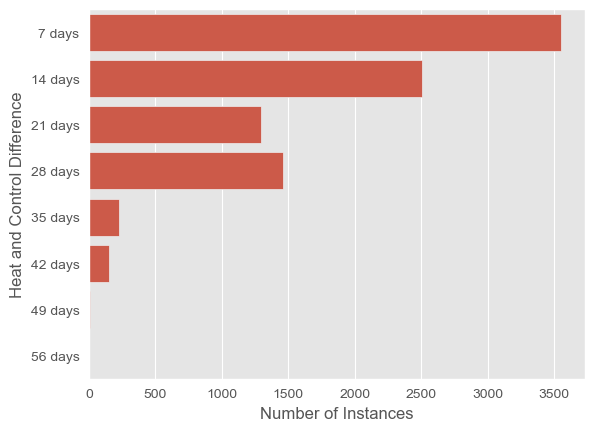

In [9]:
sns.barplot(temp, y=temp.index, x='Number of Instances')
plt.ylabel("Heat and Control Difference")

### Merge Mobility with Heat Data

In [10]:
mobility = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/google_mobility/NG_clean_google.csv')  

In [11]:
mobility.rename(columns = {
                                'retail_and_recreation_percent_change_from_baseline':'retail_rec', 
                                'grocery_and_pharmacy_percent_change_from_baseline':'grocery_pharm',
                                'parks_percent_change_from_baseline': 'parks', 
                                'transit_stations_percent_change_from_baseline': 'transit', 
                                'workplaces_percent_change_from_baseline':'workplaces',
                                'residential_percent_change_from_baseline': 'residential'}, inplace=True)
                                

In [12]:
mobility.drop_duplicates(['location', 'date'], inplace=True)

In [13]:
mobility['date'] = pd.to_datetime(mobility['date'])

In [15]:
#merge mobility data with heatwave and control day data
mobility_heat = mobility.merge(heatwave_control[['control_day', 'thi', 'location', 'datetime', 'heat_ID']], left_on=['location', 'date'], right_on=['location', 'datetime'])

In [16]:
#get mobility on control day
mobility_heat = mobility_heat.merge(mobility[['location', 'date', 'retail_rec', 'grocery_pharm', 'parks', 'transit', 'workplaces', 'residential']], left_on=['location', 'control_day'], right_on=['location', 'date'], suffixes=['_heat', '_control'])

In [17]:
#calculate differences between heat and control 
mobility_heat['retail_rec_difference'] = mobility_heat['retail_rec_heat'] - mobility_heat['retail_rec_control']
mobility_heat['grocery_pharm_difference'] = mobility_heat['grocery_pharm_heat'] - mobility_heat['grocery_pharm_control']
mobility_heat['parks_difference'] = mobility_heat['parks_heat'] - mobility_heat['parks_control']
mobility_heat['transit_difference'] = mobility_heat['transit_heat'] - mobility_heat['transit_control']
mobility_heat['workplaces_difference'] = mobility_heat['workplaces_heat'] - mobility_heat['workplaces_control']
mobility_heat['residential_difference'] = mobility_heat['residential_heat'] - mobility_heat['residential_control']

In [18]:
mobility_heat['day_of_week'] = [x.day_of_week for x in mobility_heat['date_heat']]
mobility_heat['weekend'] = [1 if x in [5,6] else 0 for x in mobility_heat['day_of_week']]

In [19]:
mobility_heat.reset_index(drop=True,inplace=True)

In [20]:
mobility_heat

,Unnamed: 0,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,date_heat,...,workplaces_control,residential_control,retail_rec_difference,grocery_pharm_difference,parks_difference,transit_difference,workplaces_difference,residential_difference,day_of_week,weekend
0,641,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,2022-03-07,...,-29.0,NaN,NaN,-2.0,NaN,NaN,1.0,NaN,0,0
1,642,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,2022-03-08,...,41.0,NaN,NaN,6.0,NaN,NaN,13.0,NaN,1,0
2,929,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,2022-03-07,...,-42.0,NaN,10.0,NaN,NaN,-27.0,1.0,NaN,0,0
3,930,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,2022-03-08,...,39.0,NaN,19.0,NaN,NaN,6.0,15.0,NaN,1,0
4,951,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,2022-03-29,...,51.0,NaN,6.0,NaN,NaN,11.0,6.0,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,55163,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,2022-04-14,...,151.0,NaN,NaN,-12.0,NaN,NaN,-15.0,NaN,3,0
1484,55168,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,2022-04-21,...,151.0,NaN,NaN,-29.0,NaN,NaN,-20.0,NaN,3,0
1485,55158,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,2022-04-08,...,149.0,NaN,NaN,4.0,NaN,NaN,1.0,NaN,4,0
1486,55169,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,2022-04-22,...,101.0,NaN,NaN,9.0,NaN,NaN,46.0,NaN,4,0


In [21]:
mobility_heat['datetime'] = pd.to_datetime(mobility_heat['datetime'])

In [22]:
mobility_heat.to_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/nigeria/THI_mobility_heat_clean_90.csv')